In [1]:
import pandas as pd
import numpy as np
import time                     #python 自带
from astropy.time import Time   #astropy 
from astropy import units as u 
from astropy import constants as const #import constants 
from astropy.coordinates import cartesian_to_spherical
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
import ligo.skymap.plot

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage#动图生成
import moviepy.editor as mpy

####teukolsky
from lib.waveform import teukolsky
from lib.waveform import get_td_waveform

from scipy.interpolate import interp1d

from fpfc2w import *


orbitDataTAIJI  =  pd.read_csv('orbitData/orbitDataTAIJI.dat', index_col = 0)  #读取csv文件
orbitData      =  orbitDataTAIJI.loc[0:366,:]

sunPX = orbitData['sunPX']
sunPY = orbitData['sunPY']
sunPZ = orbitData['sunPZ']

earthPX = orbitData['earthPX']
earthPY = orbitData['earthPY']
earthPZ = orbitData['earthPZ']

scp1X = orbitData['scp1X']
scp1Y = orbitData['scp1Y']
scp1Z = orbitData['scp1Z']

scp2X = orbitData['scp2X']
scp2Y = orbitData['scp2Y']
scp2Z = orbitData['scp2Z']

scp3X = orbitData['scp3X']
scp3Y = orbitData['scp3Y']
scp3Z = orbitData['scp3Z']

scpX = (scp1X + scp2X + scp3X) / 3  
scpY = (scp1Y + scp2Y + scp3Y) / 3  
scpZ = (scp1Z + scp2Z + scp3Z) / 3  

scp = (np.vstack([scpX, scpY, scpZ])).T
scp1 = (np.vstack([scp1X, scp1Y, scp1Z])).T
scp2 = (np.vstack([scp2X, scp2Y, scp2Z])).T
scp3 = (np.vstack([scp3X, scp3Y, scp3Z])).T


d12 = scp2 - scp1 
d13 = scp3 - scp1
xd  = d12 + d13

ed12 = d12 / np.linalg.norm(d12, axis=1, keepdims=True)
ed13 = d13 / np.linalg.norm(d13, axis=1, keepdims=True)


exd = xd / np.linalg.norm(xd, axis=1, keepdims=True)
ezd = vecCross(ed13, ed12)
eyd = vecCross(ezd, exd)


trans = transMat(exd, eyd, ezd)


NVec = np.array([[-0.21754308, -0.88794532, -0.40525068]]) #randUnitVec(1)
LVec = NVec + np.array([[1e-13,1e-13,1e-13]])#randUnitVec(1)

LVec = LVec / np.linalg.norm(LVec, axis=1, keepdims=True)

thetaPhi = W2ThetaPhi(trans, NVec)
theta = thetaPhi[:,0]
phi = thetaPhi[:,1]
psi = LNZ2Psi(LVec, NVec, ezd)[:,0]

####
Fp1 = Fplus1(theta, phi, psi)
Fc1 =  Fcross1(theta, phi, psi)
Fp2 = Fplus2(theta, phi, psi)
Fc2 =  Fcross2(theta, phi, psi)

ans = np.vstack([Fp1, Fc1, Fp2, Fc2]).T


timeVec = orbitData['timeJD']

timeVecSec = (timeVec - 2461853.0) * 86400
fp1 =interp1d(timeVecSec, Fp1,kind='cubic')#三次样条插值
fc1 =interp1d(timeVecSec, Fc1,kind='cubic')#三次样条插值

# show

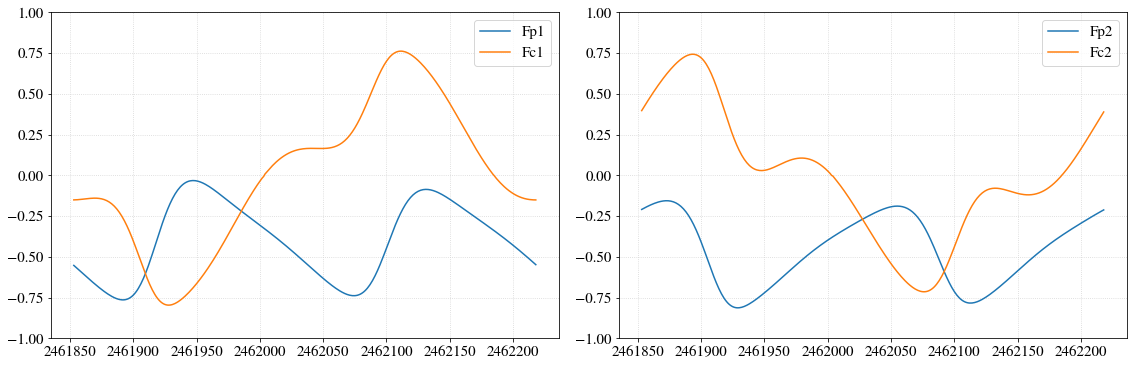

In [2]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(16,8/1.5))
plt.subplot(121)
plt.plot(timeVec, Fp1, label='Fp1')
plt.plot(timeVec, Fc1, label='Fc1')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.subplot(122)
plt.plot(timeVec, Fp2, label='Fp2')
plt.plot(timeVec, Fc2, label='Fc2')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.show()

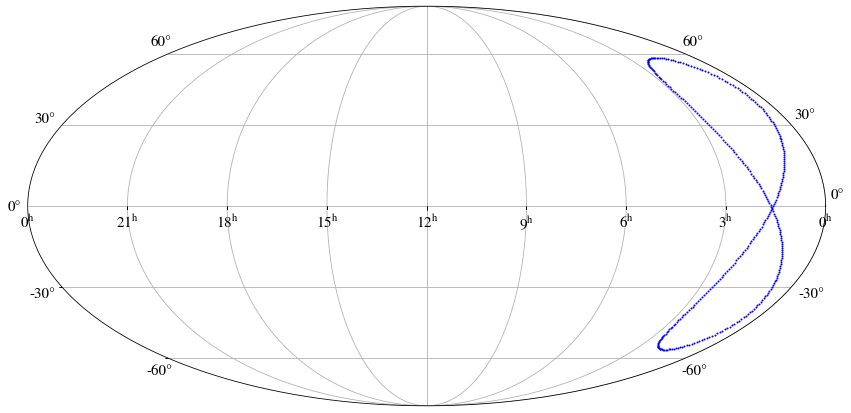

In [3]:

source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图
C_center = SkyCoord(8*np.pi/8 , -2*np.pi/8, unit="radian", frame = 'icrs')  # defaults to ICRS frame

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='astro hours mollweide')

ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

# waveform

In [5]:
#####波形参数###########################################################################

# MassBH    = 1e6
# SpinxBH   = 0
# SpinyBH   = 0
# SpinzBH   = 0.9
# MassCO    = 1e1
# SpinxCO   = 0 
# SpinyCO   = 0
# SpinzCO   = 90
# ECC       = 0.5
# PM        = 20
# IOTA      = 0.25


# kwargs = dict(MassBH=MassBH, SpinxBH=SpinxBH, SpinyBH=SpinyBH, SpinzBH=SpinzBH, \
#     MassCO=MassCO, SpinxCO=SpinxCO, SpinyCO=SpinyCO, SpinzCO=SpinzCO, ECC=ECC, PM=PM, IOTA=IOTA)

# wave = WaveDataOut(**kwargs)



wave =  pd.read_csv('./others/waveDataEMRImonth.dat', index_col = 0)  #读取csv文件
data  =  wave
fp1Factor = fp1(data['timeSecond'])
fc1Factor = fc1(data['timeSecond'])
ht = np.sqrt(3)/2 * (fp1Factor * data['hp'] + fc1Factor * data['hc'])

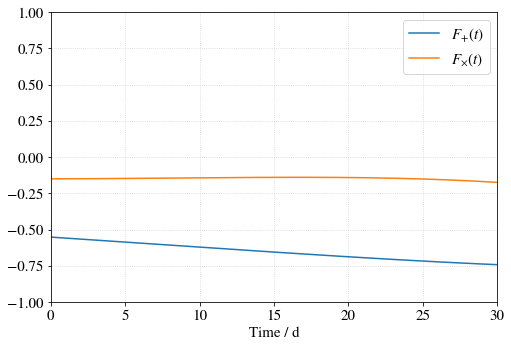

In [6]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(8,8/1.5))
plt.plot(data['timeSecond'], fp1Factor, label='$F_{+}(t)$')
plt.plot(data['timeSecond'], fc1Factor, label='$F_{\\times}(t)$')
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])
plt.show()

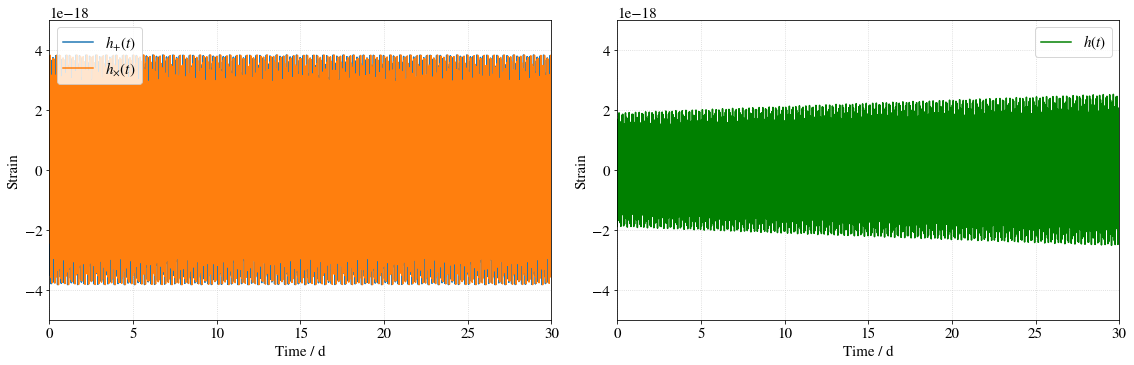

In [8]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

data  =  wave
plt.figure(figsize=(16, 8/1.5))
plt.subplot(121)
plt.plot(data['timeSecond'], data['hp'], label = '$h_{+}(t)$')
plt.plot(data['timeSecond'], data['hc'], label = '$h_{\\times}(t)$')

plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])

plt.ylim(- 5e-18, 5e-18)
plt.ylabel("Strain")
plt.legend()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")



plt.subplot(122)
plt.plot(data['timeSecond'],  ht, label = '$h(t)$', c='green')
plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])

plt.ylim(- 5e-18, 5e-18)
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()